In each data fold, there is a raw data subfolder and a syn data subfolder, which represent the raw data collection without synchronisation but with high precise timestep, and the synchronised data but without high precise timestep.

Here is the header of the sensor file and ground truth file.

## vicon (vi*.csv)

Time  Header  translation.x translation.y translation.z rotation.x rotation.y rotation.z rotation.w

## Sensors (imu*.csv)

Time attitude_roll(radians) attitude_pitch(radians) attitude_yaw(radians) rotation_rate_x(radians/s) rotation_rate_y(radians/s) rotation_rate_z(radians/s) gravity_x(G) gravity_y(G) gravity_z(G) user_acc_x(G) user_acc_y(G) user_acc_z(G) magnetic_field_x(microteslas) magnetic_field_y(microteslas) magnetic_field_z(microteslas)

## Structure

In this folder
```
user@fedora ~/C/magnetic_localization (master)> ls data/Oxford\ Inertial\ Odometry\ Dataset/handheld/
data1/  data3/  data5/          Test.txt*
data2/  data4/  handheld.xlsx*  Train.txt*
user@fedora ~/C/magnetic_localization (master)> ls data/Oxford\ Inertial\ Odometry\ Dataset/handheld/data1/syn/
imu1.csv*  imu4.csv*  imu7.csv*  vi3.csv*  vi6.csv*
imu2.csv*  imu5.csv*  vi1.csv*   vi4.csv*  vi7.csv*
imu3.csv*  imu6.csv*  vi2.csv*   vi5.csv*
user@fedora ~/C/magnetic_localization (master)> ls data/Oxford\ Inertial\ Odometry\ Dataset/handheld/data2/syn/
imu1.csv*  imu2.csv*  imu3.csv*  vi1.csv*  vi2.csv*  vi3.csv*
user@fedora ~/C/magnetic_localization (master)> ls data/Oxford\ Inertial\ Odometry\ Dataset/handheld/data3/syn/
imu1.csv*  imu3.csv*  imu5.csv*  vi2.csv*  vi4.csv*
imu2.csv*  imu4.csv*  vi1.csv*   vi3.csv*  vi5.csv*
user@fedora ~/C/magnetic_localization (master)> ls data/Oxford\ Inertial\ Odometry\ Dataset/handheld/
data1/  data3/  data5/          Test.txt*
data2/  data4/  handheld.xlsx*  Train.txt*
user@fedora ~/C/magnetic_localization (master)> pwd
/home/user/Code/magnetic_localization
```

Also like each of them are the same length, so no need to sync the timesteps
```
user@fedora ~/C/magnetic_localization (master)> cat data/Oxford\ Inertial\ Odometry\ Dataset/handheld/data1/syn/imu2.csv |wc
  23446   23446 3282548
user@fedora ~/C/magnetic_localization (master)> cat data/Oxford\ Inertial\ Odometry\ Dataset/handheld/data1/syn/vi2.csv |wc
  23446   23446 1740520
```

Just fucking ignore the Time and Header

## Some more Information
```
user@fedora ~/C/m/d/O/h/d/syn (master)> pwd
/home/user/Code/magnetic_localization/data/Oxford Inertial Odometry Dataset/handheld/data1/syn
user@fedora ~/C/m/d/O/h/d/syn (master)> ls
imu1.csv*  imu4.csv*  imu7.csv*  vi3.csv*  vi6.csv*
imu2.csv*  imu5.csv*  vi1.csv*   vi4.csv*  vi7.csv*
imu3.csv*  imu6.csv*  vi2.csv*   vi5.csv*
user@fedora ~/C/m/d/O/h/d/syn (master)> cat imu1.csv |head -n 5
1.50E+11,0.003649,0.44925,-0.21255,0.036483,-0.029496,0.020632,0.003286,-0.43429,-0.90077,-0.002798,0.014599,-0.016836,-2.3577,-0.3717,-42.347
1.50E+11,0.00305,0.44954,-0.21219,0.067307,-0.038284,0.029241,0.002747,-0.43455,-0.90064,-0.004578,0.013712,-0.013968,-2.3576,-0.37186,-42.272
1.50E+11,0.002363,0.45003,-0.21184,0.076935,-0.039423,0.021788,0.002128,-0.43499,-0.90043,-0.007743,0.013192,-0.008427,-2.3576,-0.37186,-42.272
1.50E+11,0.001778,0.45053,-0.21167,0.066339,-0.039321,0.006826,0.001601,-0.43544,-0.90021,-0.006255,0.011814,-0.003259,-2.207,-0.59618,-42.27
1.50E+11,0.001393,0.45086,-0.21171,0.037685,-0.030543,-0.010317,0.001253,-0.43574,-0.90007,-0.003634,0.008648,0.000367,-2.207,-0.59618,-42.27
user@fedora ~/C/m/d/O/h/d/syn (master)> cat vi1.csv |head -n 5
1.50E+11,12978,-1.2991,1.7212,1.1931,-0.21409,-0.012459,-0.097183,0.97189
1.50E+11,12979,-1.2993,1.7213,1.1932,-0.21473,-0.01237,-0.097239,0.97174
1.50E+11,12980,-1.2993,1.7213,1.1932,-0.21509,-0.012288,-0.097244,0.97166
1.50E+11,12981,-1.2994,1.7214,1.1933,-0.21526,-0.012291,-0.09738,0.97161
1.50E+11,12982,-1.2995,1.7213,1.1933,-0.21541,-0.012199,-0.097503,0.97157
```

Note: Use os list dir instead of hardcoding data folders

# **YOU MUST SPLIT DATA AT THE FILE LEVEL TO PREVENT LEAKAGE**

## Goal

Our goal is to predict the current `x`, `y`, `z` based on the previous all previous data(but not previous `x`, `y`, `z`)

## LSTM Model

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class IMUSequence:
    def __init__(self, imu_file, vi_file, sequence_length):
        imu_data = pd.read_csv(imu_file, header=None).iloc[:, 1:].values
        vi_data = pd.read_csv(vi_file, header=None).iloc[:, 2:5].values  # Only x, y, z

        self.sequences = []
        self.targets = []

        for i in range(0, len(imu_data) - sequence_length, sequence_length):
            self.sequences.append(imu_data[i:i+sequence_length])
            self.targets.append(vi_data[i+sequence_length])

        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)

class IMUDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = []
        self.targets = []
        for seq in sequences:
            self.sequences.extend(seq.sequences)
            self.targets.extend(seq.targets)
        
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.targets[idx])

def load_sequences(root_dir, sequence_length):
    sequences = []
    for data_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, data_folder, 'syn')
        if os.path.isdir(folder_path):
            imu_files = sorted([f for f in os.listdir(folder_path) if f.startswith('imu')])
            vi_files = sorted([f for f in os.listdir(folder_path) if f.startswith('vi')])
            
            for imu_file, vi_file in zip(imu_files, vi_files):
                sequences.append(IMUSequence(
                    os.path.join(folder_path, imu_file),
                    os.path.join(folder_path, vi_file),
                    sequence_length
                ))
    return sequences

class IMULSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(IMULSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
sequence_length = 100
input_size = 15  # Number of features in IMU data
hidden_size = 64
num_layers = 2
output_size = 3  # x, y, z
learning_rate = 0.001
batch_size = 32
num_epochs = 50

# Load all sequences
root_dir = '/home/user/Code/magnetic_localization/data/Oxford Inertial Odometry Dataset/handheld'
all_sequences = load_sequences(root_dir, sequence_length)

# Split sequences into train and validation at the file level
train_sequences, val_sequences = train_test_split(all_sequences, test_size=0.1, random_state=42)

# Create datasets
train_dataset = IMUDataset(train_sequences)
val_dataset = IMUDataset(val_sequences)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



# Print total amount of data
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")
print(f"Total samples: {len(train_dataset) + len(val_dataset)}")

# If you want to print the shape of the data
print(f"Input shape: {train_dataset[0][0].shape}")
print(f"Target shape: {train_dataset[0][1].shape}")

# If you want to print the number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")



# Initialize the model, loss function, and optimizer
model = IMULSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def mean_baseline_eval(loader, mean_position):
    total_loss = 0
    for _, targets in loader:
        batch_size = targets.size(0)
        mean_predictions = mean_position.repeat(batch_size, 1)
        loss = torch.nn.functional.mse_loss(mean_predictions, targets)
        total_loss += loss.item() * batch_size
    return total_loss / len(loader.dataset)

# Calculate mean position from the training set
all_targets = torch.cat([targets for _, targets in train_loader], dim=0)
mean_position = all_targets.mean(dim=0)
# Perform mean baseline evaluation
print("Performing mean baseline evaluation...")
baseline_train_loss = mean_baseline_eval(train_loader, mean_position)
baseline_val_loss = mean_baseline_eval(val_loader, mean_position)
print(f"Baseline Train Loss: {baseline_train_loss:.4f}, Baseline Val Loss: {baseline_val_loss:.4f}")

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (imu_seq, vi_target) in enumerate(train_loader):
        outputs = model(imu_seq)
        loss = criterion(outputs, vi_target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imu_seq, vi_target in val_loader:
            outputs = model(imu_seq)
            val_loss += criterion(outputs, vi_target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_imu_lstm_model.pth')

print("Training completed.")

Total training samples: 6002
Total validation samples: 981
Total samples: 6983
Input shape: torch.Size([100, 15])
Target shape: torch.Size([3])
Number of training batches: 188
Number of validation batches: 31
Performing mean baseline evaluation...
Baseline Train Loss: 1.5063, Baseline Val Loss: 1.6076
Epoch [1/50], Train Loss: 1.1398, Val Loss: 0.8653
Epoch [2/50], Train Loss: 0.7789, Val Loss: 0.7600
Epoch [3/50], Train Loss: 0.6429, Val Loss: 1.2881
Epoch [4/50], Train Loss: 0.6103, Val Loss: 0.5146
Epoch [5/50], Train Loss: 0.5127, Val Loss: 0.5377
Epoch [6/50], Train Loss: 0.5032, Val Loss: 0.5053
Epoch [7/50], Train Loss: 0.4625, Val Loss: 0.4680
Epoch [8/50], Train Loss: 0.4413, Val Loss: 0.4446
Epoch [9/50], Train Loss: 0.4472, Val Loss: 0.4300
Epoch [10/50], Train Loss: 0.4182, Val Loss: 0.4342
Epoch [11/50], Train Loss: 0.4094, Val Loss: 0.4288
Epoch [12/50], Train Loss: 0.4079, Val Loss: 0.4226
Epoch [13/50], Train Loss: 0.3714, Val Loss: 0.4357
Epoch [14/50], Train Loss: 0.3

KeyboardInterrupt: 

/tmp/ipykernel_143026/458679718.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_imu_lstm_model.pth'))


Test Loss: 0.4825
Mean Absolute Error: X: 0.4763, Y: 0.7217, Z: 0.0273
Root Mean Square Error: X: 0.7043, Y: 0.9745, Z: 0.0345


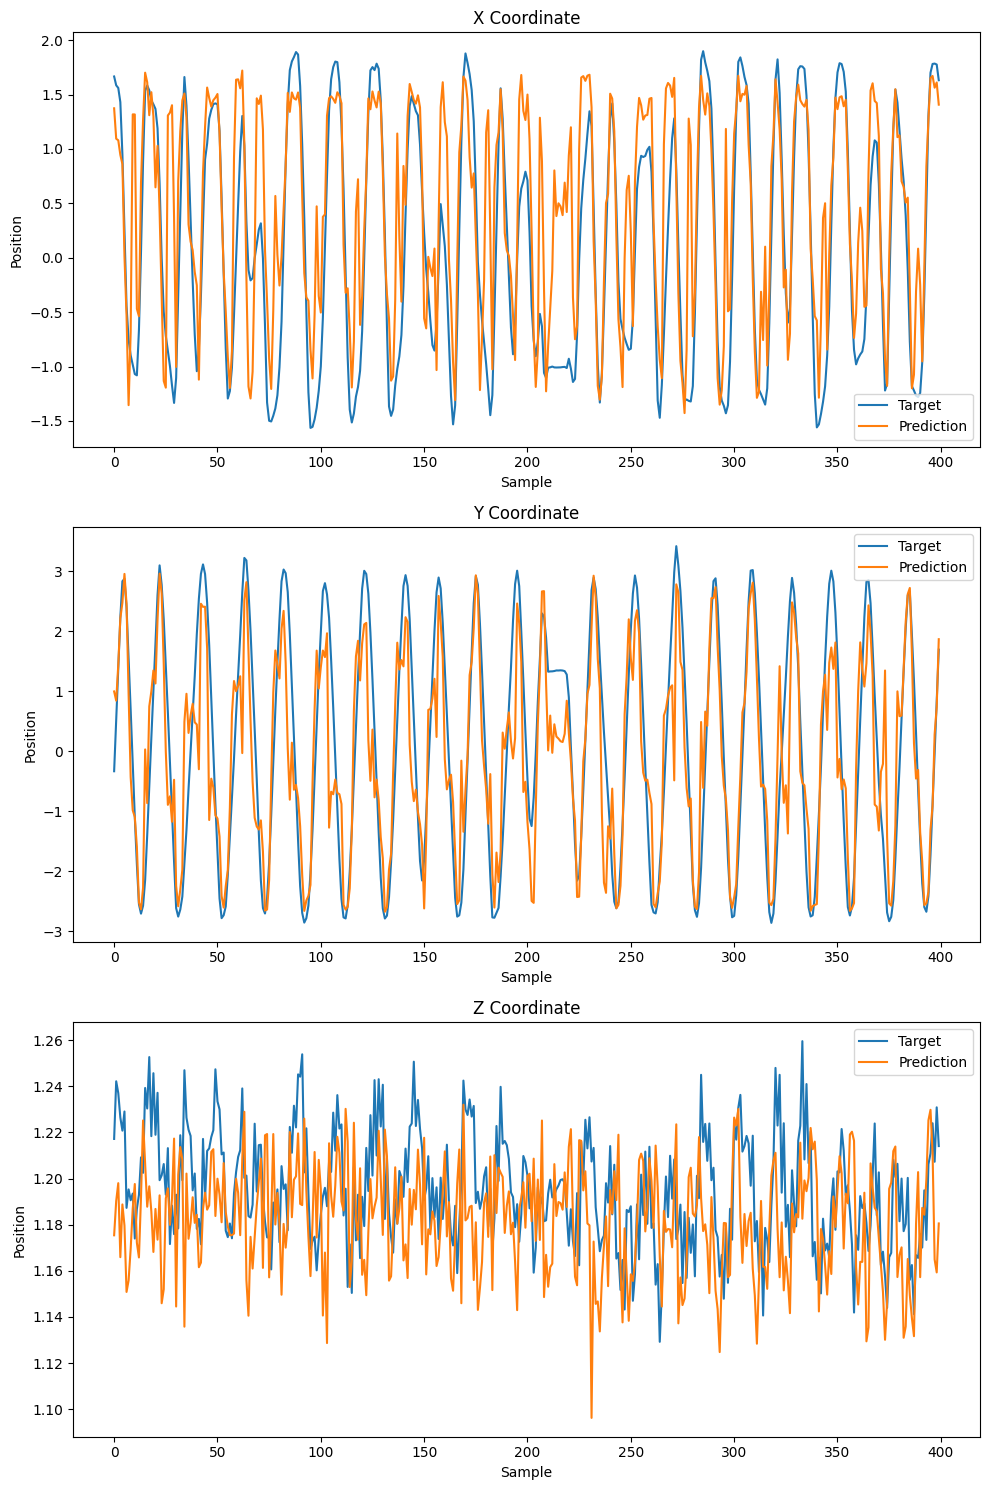

Overall MAE: 0.4084
Overall RMSE: 0.6945
Mean Euclidean Distance Error: 0.9736
Median Euclidean Distance Error: 0.7729


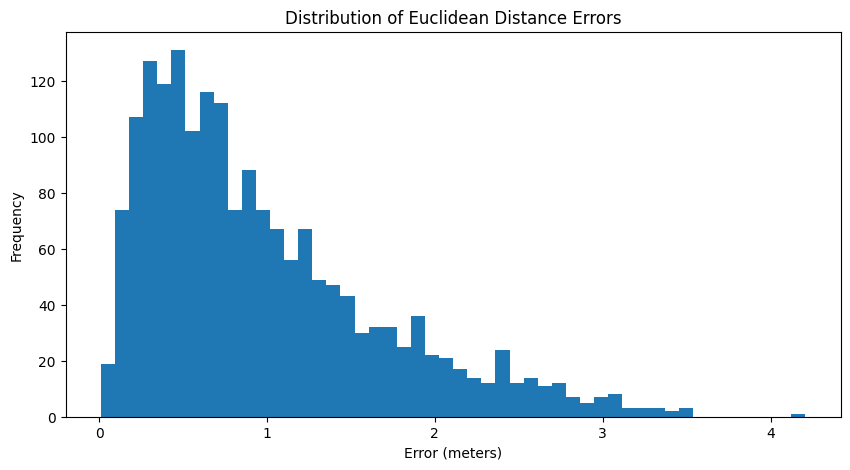

In [10]:
# Load test sequences
test_root_dir = '/home/user/Code/magnetic_localization/data/Oxford Inertial Odometry Dataset/handheld_test'
test_sequences = load_sequences(test_root_dir, sequence_length)

# Create test dataset and dataloader
test_dataset = IMUDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the best model
model.load_state_dict(torch.load('best_imu_lstm_model.pth'))
model.eval()

# Evaluation on test set
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for imu_seq, vi_target in test_loader:
        outputs = model(imu_seq)
        test_loss += criterion(outputs, vi_target).item()
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(vi_target.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Convert predictions and targets to numpy arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Calculate Mean Absolute Error (MAE) for each dimension
mae = np.mean(np.abs(test_predictions - test_targets), axis=0)
print(f'Mean Absolute Error: X: {mae[0]:.4f}, Y: {mae[1]:.4f}, Z: {mae[2]:.4f}')

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((test_predictions - test_targets)**2, axis=0))
print(f'Root Mean Square Error: X: {rmse[0]:.4f}, Y: {rmse[1]:.4f}, Z: {rmse[2]:.4f}')

# Visualize predictions vs. targets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
dimensions = ['X', 'Y', 'Z']

for i in range(3):
    axs[i].plot(test_targets[100:500, i], label='Target')
    axs[i].plot(test_predictions[100:500, i], label='Prediction')
    axs[i].set_title(f'{dimensions[i]} Coordinate')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Position')
    axs[i].legend()

plt.tight_layout()
plt.show()

# Calculate and print the overall MAE and RMSE
overall_mae = np.mean(np.abs(test_predictions - test_targets))
overall_rmse = np.sqrt(np.mean((test_predictions - test_targets)**2))
print(f'Overall MAE: {overall_mae:.4f}')
print(f'Overall RMSE: {overall_rmse:.4f}')

# Calculate and print the Euclidean distance error
euclidean_distances = np.sqrt(np.sum((test_predictions - test_targets)**2, axis=1))
mean_distance_error = np.mean(euclidean_distances)
median_distance_error = np.median(euclidean_distances)
print(f'Mean Euclidean Distance Error: {mean_distance_error:.4f}')
print(f'Median Euclidean Distance Error: {median_distance_error:.4f}')

# Plot the distribution of Euclidean distance errors
plt.figure(figsize=(10, 5))
plt.hist(euclidean_distances, bins=50)
plt.title('Distribution of Euclidean Distance Errors')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

## Transformer Based Model

In [ ]:
class IMUSequence:
    def __init__(self, imu_file, vi_file, sequence_length):
        imu_data = pd.read_csv(imu_file, header=None).iloc[:, 1:].values
        vi_data = pd.read_csv(vi_file, header=None).iloc[:, 2:5].values  # Only x, y, z

        self.sequences = []
        self.targets = []

        for i in range(0, len(imu_data) - sequence_length, sequence_length):
            self.sequences.append(imu_data[i:i+sequence_length])
            self.targets.append(vi_data[i+sequence_length])

        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)

class IMUDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = []
        self.targets = []
        for seq in sequences:
            self.sequences.extend(seq.sequences)
            self.targets.extend(seq.targets)
        
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.targets[idx])

def load_sequences(root_dir, sequence_length):
    sequences = []
    for data_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, data_folder, 'syn')
        if os.path.isdir(folder_path):
            imu_files = sorted([f for f in os.listdir(folder_path) if f.startswith('imu')])
            vi_files = sorted([f for f in os.listdir(folder_path) if f.startswith('vi')])
            
            for imu_file, vi_file in zip(imu_files, vi_files):
                sequences.append(IMUSequence(
                    os.path.join(folder_path, imu_file),
                    os.path.join(folder_path, vi_file),
                    sequence_length
                ))
    return sequences

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class IMUTransformerModel(torch.nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, output_size):
        super(IMUTransformerModel, self).__init__()
        self.embedding = torch.nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = torch.nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = torch.nn.Linear(d_model, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

# Hyperparameters
sequence_length = 100
input_size = 15  # Number of features in IMU data
d_model = 64
nhead = 4
num_layers = 2
output_size = 3  # x, y, z
learning_rate = 0.001
batch_size = 32
num_epochs = 50

# Load all sequences
root_dir = '/home/user/Code/magnetic_localization/data/Oxford Inertial Odometry Dataset/handheld'
all_sequences = load_sequences(root_dir, sequence_length)

# Split sequences into train and validation at the file level
train_sequences, val_sequences = train_test_split(all_sequences, test_size=0.2, random_state=42)

# Create datasets
train_dataset = IMUDataset(train_sequences)
val_dataset = IMUDataset(val_sequences)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


# Print total amount of data
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")
print(f"Total samples: {len(train_dataset) + len(val_dataset)}")

# If you want to print the shape of the data
print(f"Input shape: {train_dataset[0][0].shape}")
print(f"Target shape: {train_dataset[0][1].shape}")

# If you want to print the number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Initialize the model, loss function, and optimizer
model = IMUTransformerModel(input_size, d_model, nhead, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def mean_baseline_eval(loader, mean_position):
    total_loss = 0
    for _, targets in loader:
        batch_size = targets.size(0)
        mean_predictions = mean_position.repeat(batch_size, 1)
        loss = torch.nn.functional.mse_loss(mean_predictions, targets)
        total_loss += loss.item() * batch_size
    return total_loss / len(loader.dataset)

# Calculate mean position from the training set
all_targets = torch.cat([targets for _, targets in train_loader], dim=0)
mean_position = all_targets.mean(dim=0)

# Perform mean baseline evaluation
print("Performing mean baseline evaluation...")
baseline_train_loss = mean_baseline_eval(train_loader, mean_position)
baseline_val_loss = mean_baseline_eval(val_loader, mean_position)
print(f"Baseline Train Loss: {baseline_train_loss:.4f}, Baseline Val Loss: {baseline_val_loss:.4f}")

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (imu_seq, vi_target) in enumerate(train_loader):
        outputs = model(imu_seq)
        loss = criterion(outputs, vi_target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imu_seq, vi_target in val_loader:
            outputs = model(imu_seq)
            val_loss += criterion(outputs, vi_target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_imu_transformer_model.pth')

print("Training completed.")

/home/user/Code/mlenv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Performing mean baseline evaluation...
Baseline Train Loss: 1.5041, Baseline Val Loss: 1.5793
Epoch [1/50], Train Loss: 1.3269, Val Loss: 1.3490
Epoch [2/50], Train Loss: 1.1177, Val Loss: 1.1222
Epoch [3/50], Train Loss: 0.9491, Val Loss: 1.1633
Epoch [4/50], Train Loss: 0.8141, Val Loss: 1.0142
Epoch [5/50], Train Loss: 0.7568, Val Loss: 0.8397
Epoch [6/50], Train Loss: 0.7231, Val Loss: 0.8898
Epoch [7/50], Train Loss: 0.7262, Val Loss: 0.9370
Epoch [8/50], Train Loss: 0.6959, Val Loss: 0.9049
Epoch [9/50], Train Loss: 0.6876, Val Loss: 0.9656
Epoch [10/50], Train Loss: 0.6755, Val Loss: 0.8537
Epoch [11/50], Train Loss: 0.6606, Val Loss: 0.8393
Epoch [12/50], Train Loss: 0.6723, Val Loss: 0.8156
Epoch [13/50], Train Loss: 0.6365, Val Loss: 0.8394
Epoch [14/50], Train Loss: 0.6479, Val Loss: 0.7983
Epoch [15/50], Train Loss: 0.6188, Val Loss: 0.7860
Epoch [16/50], Train Loss: 0.6323, Val Loss: 0.8043


KeyboardInterrupt: 

/tmp/ipykernel_123814/3671054110.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_imu_transformer_model.pth'))


Test Loss: 1.0276
Mean Absolute Error: X: 0.7596, Y: 1.1154, Z: 0.0601
Root Mean Square Error: X: 1.0058, Y: 1.4479, Z: 0.0759


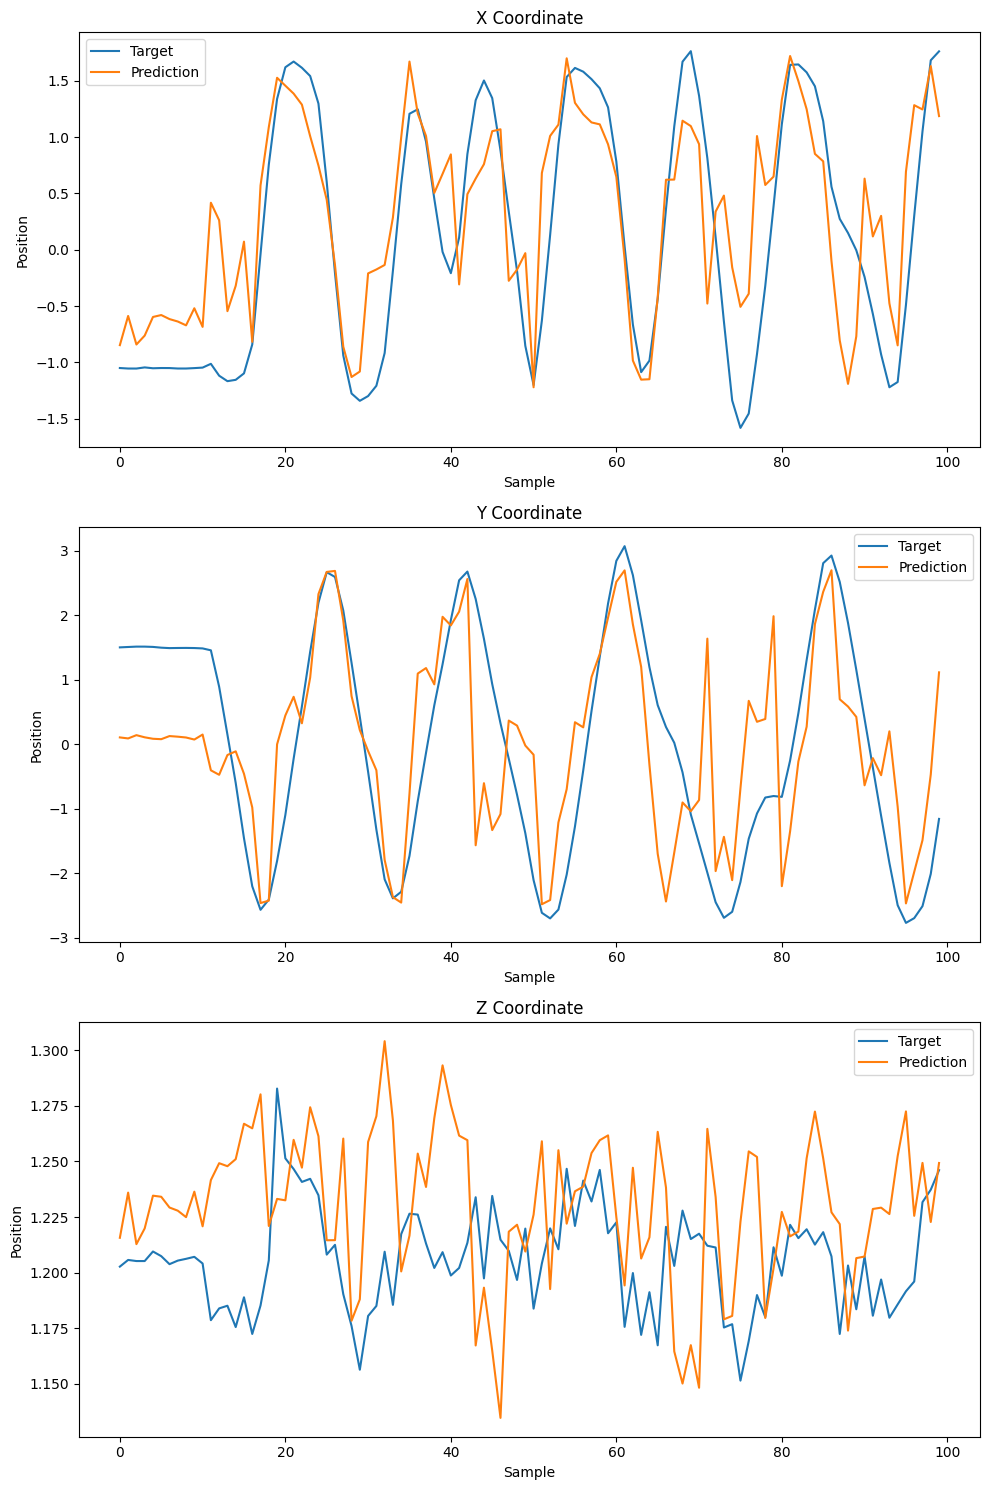

In [ ]:
import os

# Load test sequences
test_root_dir = '/home/user/Code/magnetic_localization/data/Oxford Inertial Odometry Dataset/handheld_test'
test_sequences = load_sequences(test_root_dir, sequence_length)

# Create test dataset and dataloader
test_dataset = IMUDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the best model
model.load_state_dict(torch.load('best_imu_transformer_model.pth'))
model.eval()

# Evaluation on test set
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for imu_seq, vi_target in test_loader:
        outputs = model(imu_seq)
        test_loss += criterion(outputs, vi_target).item()
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(vi_target.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Convert predictions and targets to numpy arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Calculate Mean Absolute Error (MAE) for each dimension
mae = np.mean(np.abs(test_predictions - test_targets), axis=0)
print(f'Mean Absolute Error: X: {mae[0]:.4f}, Y: {mae[1]:.4f}, Z: {mae[2]:.4f}')

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((test_predictions - test_targets)**2, axis=0))
print(f'Root Mean Square Error: X: {rmse[0]:.4f}, Y: {rmse[1]:.4f}, Z: {rmse[2]:.4f}')

# Visualize predictions vs. targets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
dimensions = ['X', 'Y', 'Z']

for i in range(3):
    axs[i].plot(test_targets[:100, i], label='Target')
    axs[i].plot(test_predictions[:100, i], label='Prediction')
    axs[i].set_title(f'{dimensions[i]} Coordinate')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Position')
    axs[i].legend()

plt.tight_layout()
plt.show()